# Example spin echo
for the Ph.D. Training program of the German Chapter of the ISMRM

https://github.com/pulseq/MR-Physics-with-Pulseq/tree/main/tutorials/01_basic_sequences/notebooks

In [ ]:
!pip show pypulseq || pip install git+https://github.com/imr-framework/pypulseq.git &> /dev/null
!wget https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py &> /dev/null

In [ ]:
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as mr

In [ ]:
# SETUP
# Set system limits
system = mr.Opts(
    max_grad=32,
    grad_unit="mT/m",
    max_slew=130,
    slew_unit="T/m/s",
    rf_ringdown_time=30e-6,
    rf_dead_time=100e-6,
)

# Create 90 degree slice selection pulse and gradient
rf_ex, gz1, _ = mr.make_sinc_pulse(
    flip_angle=90 * np.pi / 180,
    system=system,
    duration=1e-3,
    slice_thickness=5e-3,
    apodization=0.5,
    time_bw_product=4,
    phase_offset=0* np.pi / 180,
    return_gz=True,
)

# Create 180 degree refocusing pulse
rf_ref, _, _ = mr.make_sinc_pulse(
    flip_angle=180 * np.pi / 180,
    system=system,
    duration=1e-3,
    slice_thickness=5e-3,
    apodization=0.5,
    time_bw_product=4,
    phase_offset=90* np.pi / 180,
    return_gz=True,
)

dwell=20e-6
Nread=256
Nphase=1
print(f"The bandwidth is {1/dwell:.2f} Hz and {1/(dwell*Nread):.2f} Hz/px for the {Nread*dwell*1000:.2f} ms ADC.")

adc = mr.make_adc(
    num_samples=Nread,
    duration=Nread*dwell,
    phase_offset=0* np.pi / 180,
    delay=1e-5,
    system=system,)

The bandwidth is 50000.00 Hz and 195.31 Hz/px for the 5.12 ms ADC.


# Calculate delays

To calculate some important durations there exists some function:
```
rf.delay                    # delay before the start of the pulse due to dead time or gradient rise time
ct=mr.calc_rf_center(rf)    # rf center time returns time and index of the center of the pulse
ct[0]                       # this is the rf center time
rf.ringdown_time            # this is the rf ringdown time after the rf pulse
mr.calc_duration(rf)        # this is the rf duration including delay and ringdown time
```



In [ ]:
#@title Calculate delays
ct_ex=mr.calc_rf_center(rf_ex)    # rf center time returns time and index of the center of the pulse
print(ct_ex[0])
ct_ref=mr.calc_rf_center(rf_ex)    # rf center time returns time and index of the center of the pulse
print(ct_ref[0])
print(mr.calc_duration(rf_ex))
print(rf_ex.delay)
print(rf_ex.ringdown_time)

TE=7e-3  # wanted echo time
minTE2 = ct_ex[0]+rf_ex.ringdown_time + rf_ref.delay+ ct_ref[0]   #  center pulse to center pulse

d1=TE/2-minTE2
      # TE/2   - half ref pulse                 - half adc      -adc.delay
d2 = minTE2+d1 - ct_ref[0]+rf_ex.ringdown_time  - Nread*dwell/2 -adc.delay


0.0005
0.0005
0.00118
0.00015000000000000001
3e-05


In [ ]:
# CONSTRUCT SEQUENCE
# Create a new sequence object
seq = mr.Sequence(system)
# sequence programming
seq.add_block(rf_ex)
seq.add_block(mr.make_delay(d1))
seq.add_block(rf_ref)
seq.add_block(mr.make_delay(d2))
seq.add_block(adc)

In [ ]:
# check sequence timing
(ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

Timing check passed successfully


#Visualization and Export

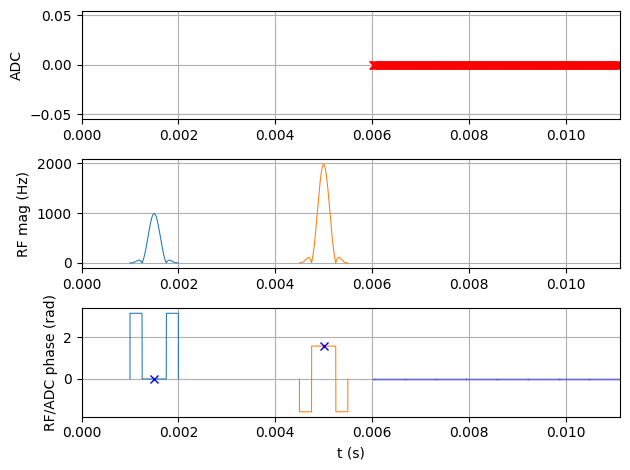

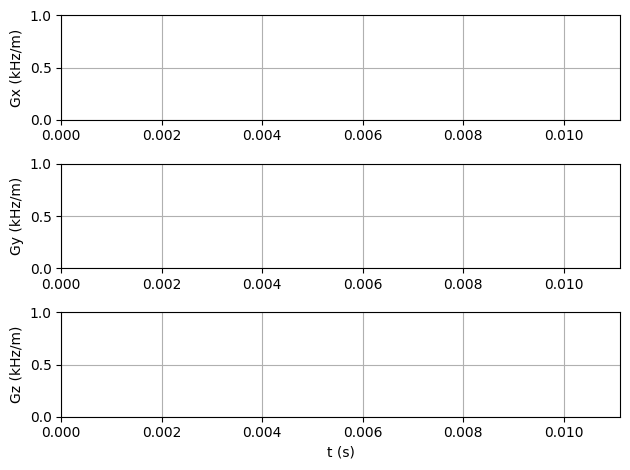

zoom in


In [ ]:
#@title plot sequence
# plot the entire sequence
seq.plot()

# plot just a small initial part
print('zoom in')
#seq.plot(time_range=[0, 0.002], time_disp="ms") #


In [ ]:
#@title write seq file and export
seq_filename='FID.seq'
seq.write(seq_filename)
#from google.colab import files
#files.download(seq_filename)  # Download locally

#Simulation

In [ ]:
#@title simulation setup
!pip show MRzeroCore || pip install MRzeroCore

!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
import utils # several helper functions for simulation and recon
import MRzeroCore as mr0


Name: MRzeroCore
Version: 0.2.9
Summary: Core functionality of MRzero
Home-page: 
Author: 
Author-email: Jonathan Endres <jonathan.endres@uk-erlangen.de>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, pydisseqt, pypulseq, requests, scikit-image, scipy, torch, torchkbnufft
Required-by: 


Calculating repetition 2 / 2 - done


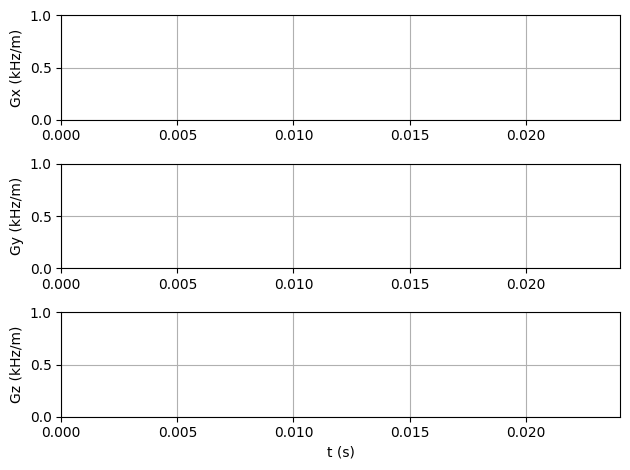

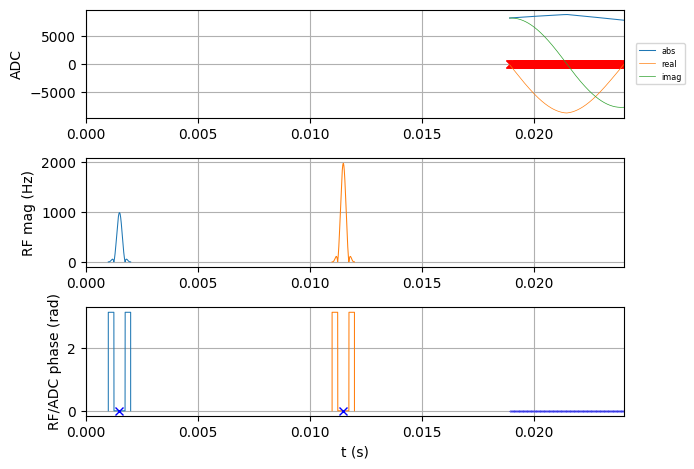

In [ ]:
#@title simulation (simple)
# kscape_adc.shape is [N_coils, N_meas, N_adc]
kspace_adc=utils.simulate_2d(seq, noise_level=0, n_coils=1, dB0=+100, B0_scale=1, B0_polynomial=None)
#sp_adc, t_adc = mr0.util.pulseq_plot(seq,signal=kspace_adc)

seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq,kspace_adc)
plt.show()



/usr/local/lib/python3.10/dist-packages/MRzeroCore/phantom/voxel_grid_phantom.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2 / self.size,


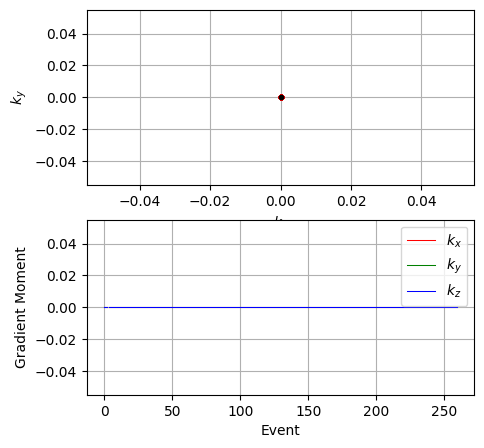

Calculating repetition 2 / 2 - done


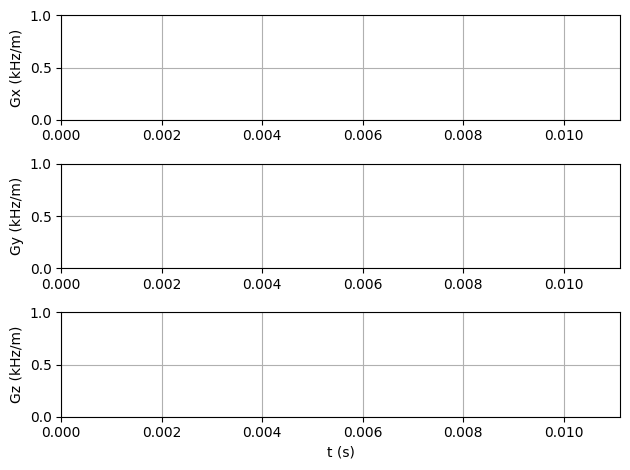

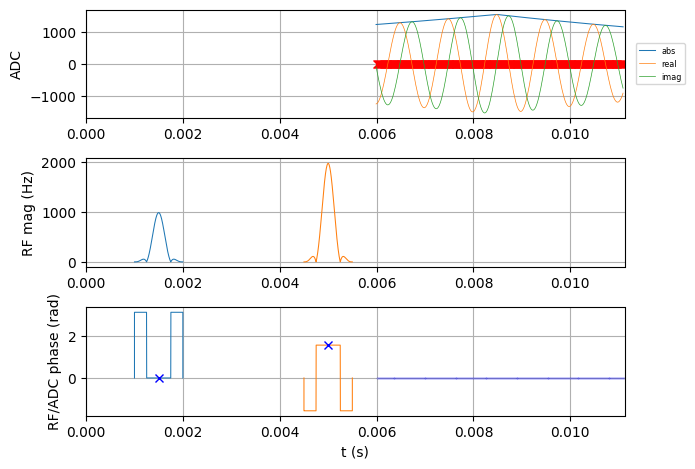

In [ ]:
#@title simulation (advanced)
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]

# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.T2dash[:] = 10e-3
obj_p.D *= 0
obj_p.B0 =obj_p.B0*0+ 1000    # alter the B0 inhomogeneity
# Store PD for comparison
PD = obj_p.PD
B0 = obj_p.B0

#obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot

# Read in the sequence
seq0 = mr0.Sequence.import_file(seq_filename)
seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 1000, 1e-5)
signal = mr0.execute_graph(graph, seq0, obj_p)

# PLOT sequence with signal in the ADC subplot
#sp_adc, t_adc = mr0.util.pulseq_plot(seq,signal=signal.numpy())


seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq,signal)
plt.show()